# ENGR E222 2021 Project 
# Default ML application for hotel booking
This is a default service where we train a logistic regression classifier to the hotel booking data set provided in class. Here we build a model to predict if a booking will be cancelled or not. 

## Step 1: Download the kaggle dataset to your google drive
https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
The above link fetches the .json file from kaggle and puts it
in the correct place to allow you to use the kaggle api to fetch data directly 
to your notebook

The kaggle package is not default in collab

In [ ]:
!pip install -q kaggle 
from google.colab import files
files.upload()

# This below is command line you can also use a mouse and make dir structure
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

## Step 2: Mount drive and define paths
Mount the drive you need to enter a link to make this work.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os

data_path = "/content/gdrive/MyDrive/Kaggle"
os.environ['KAGGLE_CONFIG_DIR'] = data_path

In [5]:
#changing the working directory
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


## Step 3: Fetch data from kaggle and unzip

This is from kaggle (navigate to the API tab and copy paste)

In [ ]:
!kaggle datasets download -d jessemostipak/hotel-booking-demand

  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 41.4MB/s]


In [ ]:
# We are now in the dir with our dataset
!ls

hotel_bookings.csv  kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
!ls

hotel_bookings.csv  kaggle.json


## Step 4: Explore and clean the data 



 Lets get the data cleaned and arranged
 https://www.kaggle.com/anushkahedaoo/hotel-booking-demand-data-cleaning

 A very useful source is here: https://scikit-learn.org/stable/modules/preprocessing.html

 Section 6.3.4 goes through the processes of encoding categorical features


In [6]:
import pandas as pd 
import numpy as np
missing_value=["Undefined"]
data = pd.read_csv("hotel_bookings.csv", na_values=missing_value) 
data.head()

#Converting the object datatype of "reservation_status_date" to datetime datatype

data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])
type(data['reservation_status_date'][0])

# Creating a new column by combining the year, month and date of arrival together.

data['arrival_date'] = pd.to_datetime(data.arrival_date_year.astype(str) + '/' + data.arrival_date_month.astype(str) + '/' + data.arrival_date_day_of_month.astype(str))

# data['arrival_date'] # check the new timestamp

#Checking how many missing values each column contains

np.sum(data.isnull())


# find the indicies of the missing data and use the 50% criteria meaning
# if there is 50% or more of data missing then we will remove the feature from 
# the data array it can be argued that a value closer to 30 % may be a better
# rule of thumb. 

my_criteria = 0.5

for col in data.columns:
    if np.sum(data[col].isnull())>(data.shape[0] * my_criteria):
        data.drop(columns=col, inplace=True, axis=1)

for col in data.columns:
    if np.sum(data[col].isnull())>(data.shape[0] * 0.5):
        data.drop(columns=col, inplace=True, axis=1)
print(data.shape)

# We combined the date above so we can drop the columns associated with the dates

data.drop(columns=["arrival_date_week_number", "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"],
           inplace=True, axis=1)

print(data.shape)

# now lets remove the rows with missing values

data.dropna(subset=["agent"], inplace=True)
print(data.shape)

data["children"].fillna(value = data["children"].mean(), inplace=True)
data["children"] = data["children"].apply(np.floor)
print(f"Total missing values in children column after filling = {np.sum(data.children.isnull())}")



colstofill=["market_segment", "distribution_channel", "meal", "country"]
print("Number of missing values are")
for x in colstofill:
    data[x].fillna(method="bfill", inplace=True)
    print(f"{x}: {np.sum(data[x].isnull())}")

np.sum(data.isnull())

# Lets get X and Y we are trying to predict a cancellation please review the 
# features that we are passing now. 

Y = data['is_canceled']
Y = Y[1:]
X = data.drop(['is_canceled'], axis=1)
X = X[1:]



(119390, 32)
(119390, 28)
(103050, 28)
Total missing values in children column after filling = 0
Number of missing values are
market_segment: 0
distribution_channel: 0
meal: 0
country: 0


In [ ]:
# If we look at X we clearly see that the there is a mixture of numbers, strings and dates.
X

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
4,Resort Hotel,14,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
5,Resort Hotel,14,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
7,Resort Hotel,9,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,0,Transient,103.00,0,1,Check-Out,2015-07-03,2015-07-01
8,Resort Hotel,85,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,82.00,0,1,Canceled,2015-05-06,2015-07-01
9,Resort Hotel,75,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,0,Transient,105.50,0,0,Canceled,2015-04-22,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,23,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30
119386,City Hotel,102,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31
119387,City Hotel,34,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31
119388,City Hotel,109,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31


In [7]:
from sklearn import preprocessing
enc = preprocessing.OrdinalEncoder()
enc.fit(X)
X_new = enc.transform(X)
X_new.shape


(103049, 27)

In [ ]:
# Need to transform cetegorical data to something the model can use

#from sklearn import preprocessing
#enc = preprocessing.OrdinalEncoder()
#col_to_trans = ['meal' , 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status'  ]
#enc.fit(X[col_to_trans])
#X_new = enc.transform(X[col_to_trans])
#X_new.shape

(103049, 9)

In [8]:
# Now we need to look at Y
# In reality a roughly 60/40 split is not awful and very representative of 'real' world data but we will balance it anyway.

from collections import Counter

original_counts = Counter(Y)
print(original_counts)

# ~62K to 40k


# now lets balance the data
from imblearn.over_sampling import SMOTE
over = SMOTE()
X_new, Y_new = over.fit_resample(X_new,Y)
new_counts = Counter(Y_new)
print(new_counts)

# The deprication warning should be resolved. https://github.com/skorch-dev/skorch/issues/612

Counter({0: 62855, 1: 40194})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 62855, 1: 62855})


## Step 5: Create the pipeline with a grid search
This has already been executed and the optimal values are used in Step 6. This step takes several minutes, especially inside the collab notebook. A nice point of discussion here is that certain uses of ML should be completed on a local system versus the cloud. This is why our service should be a trianed model as the training phase may require specialzed compute resources, but using that model can be done with little to no overhead with REST calls.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization with out the use of SMOTE.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=0)

pca = PCA()

logistic = LogisticRegression(max_iter=100000, tol=0.1)

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# This grid search is exhaustive and time consuming. 

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [2, 4, 8, 10,12,14, 16, 20, 25],
    'logistic__C': np.logspace(-4, 4, 6),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



In [ ]:
print(search.best_params_)

Best parameter (CV score=0.999):
{'logistic__C': 10000.0, 'pca__n_components': 16}
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
search.best_params_

{'logistic__C': 10000.0, 'pca__n_components': 10}

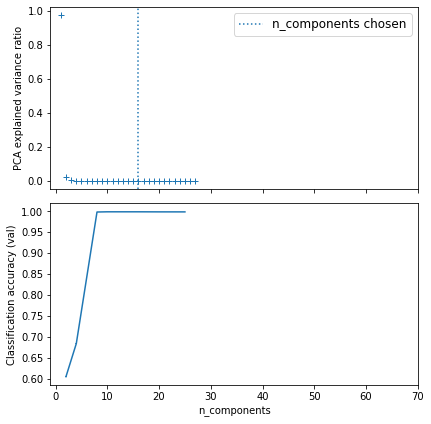

In [ ]:
# This section is about using PCA to find the optimal combination of features
# https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

pca.fit(x_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()

# Step 6: Use the values from Step 5 to train and evaluate


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=0)

pca = PCA(n_components=10)
stdscl = StandardScaler()
logistic = LogisticRegression(C = 0.15848931924611143, max_iter=100000, tol=0.1)


pipe = Pipeline(steps=[('standardscalar', stdscl),('pca', pca), ('logistic', logistic)])


In [ ]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('standardscalar',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=10000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.1, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
pipe.score(x_test,y_test)

0.9326227030466948

In [ ]:
my_prediction = pipe.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, my_prediction, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12512
           1       0.94      0.93      0.93     12630

    accuracy                           0.93     25142
   macro avg       0.93      0.93      0.93     25142
weighted avg       0.93      0.93      0.93     25142



In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, my_prediction)
conf

array([[11727,   785],
       [  909, 11721]])

In [ ]:
x_train.shape

(100568, 27)

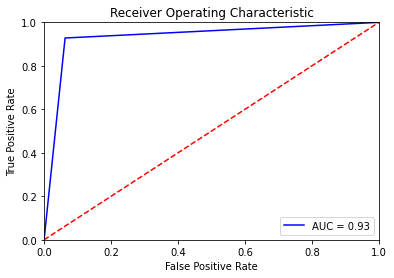

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, my_prediction)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()